BERT


Bidirectional Encoder Representations from Transformers (BERT) is a deep learning strategy for natural language processing (NLP) that helps artificial intelligence (AI) programs understand the context of ambiguous words in text.


BERT is a framework for machine learning that utilizes transformers. The transformer is where every output element is linked to every input component, and weights are assigned to establish their respective relationships. This is known as attention. BERT leverages the idea of pre-training the model on a larger dataset through unsupervised language modeling. By pre-training on a large dataset, the model can comprehend the context of the input text. Later, by fine-tuning the model on task-specific supervised data, BERT can achieve promising results.

Unlike other language models like Glove2Vec and Word2Vec, which create context-free word embeddings, BERT provides context by using bidirectional transformers.

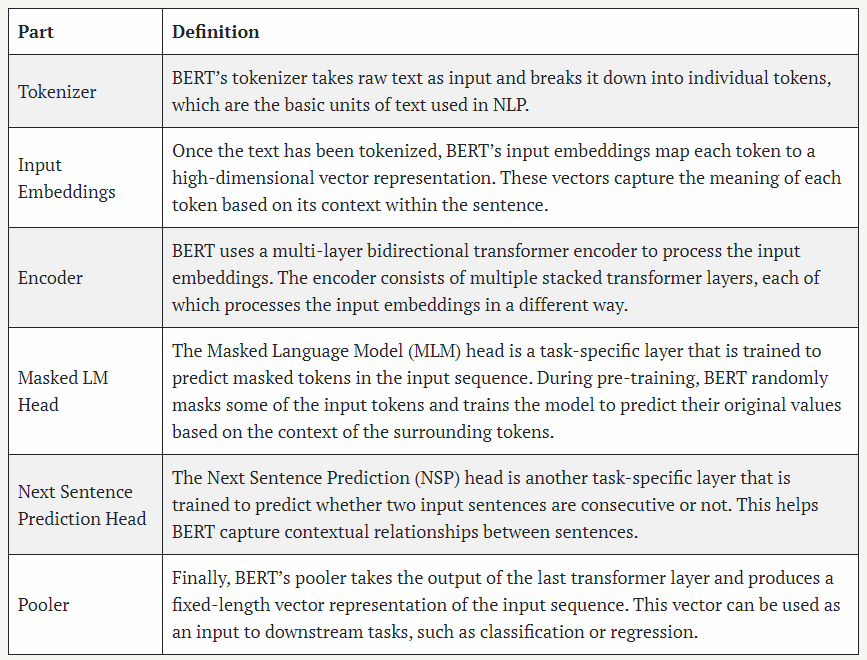

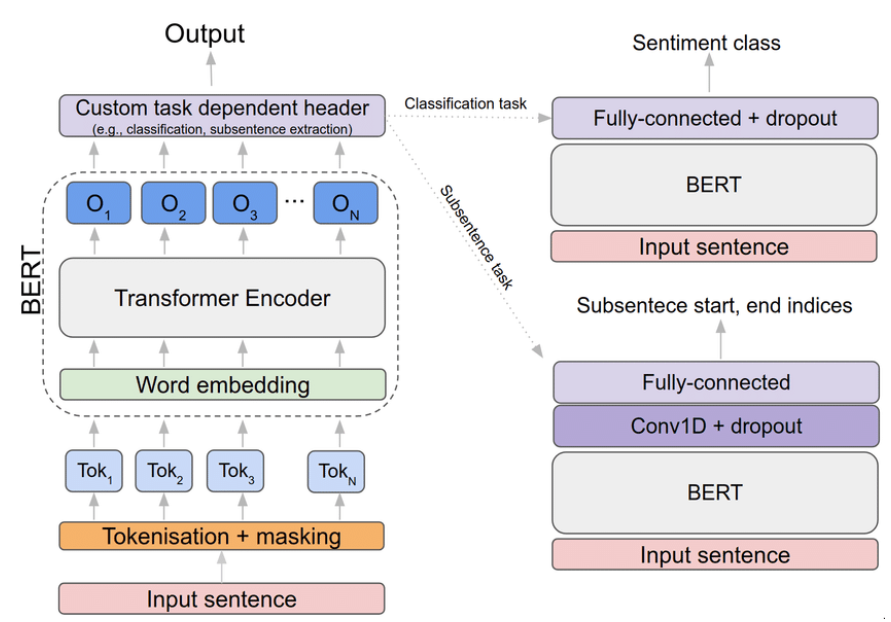

Some of the applications of the BERT Language Model in NLP include:

Sentiment Analysis

Language Translation

Question Answering

Google Search

Text Summarization

Text Matching and Retrieval

Paragraph Highlighting.

# BERT

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('TrueFalseDataFrame.csv', sep = ',')

In [ ]:
train_data, test_data = np.split(df.sample(frac=1), [int(.8*len(df))])
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print("Size of training set: {}".format(len(train_data)))
print("Size of testing set: {}".format(len(test_data)))


Size of training set: 28364
Size of testing set: 7092


In [ ]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 2

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
for param in model.parameters():
 param.requires_grad = False

model.classifier = nn.Sequential(
 nn.Linear(768, 256),
 nn.ReLU(),
 nn.Linear(256, 64),
 nn.ReLU(),
 nn.Linear(64, 2),
 nn.Softmax(dim=1)
)

model = model.to(device)

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)


In [ ]:
def preprocess_text(text):
  parts = []
  text_len = len(text.split(' '))
  delta = 300
  max_parts = 5
  nb_cuts = int(text_len / delta)
  nb_cuts = min(nb_cuts, max_parts)


  for i in range(nb_cuts + 1):
    text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
    parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

  return parts

In [ ]:
print_every = 300

total_loss = 0
all_losses = []

CUDA_LAUNCH_BLOCKING=1

model.train()

for idx, row in train_data.iterrows():
  text_parts = preprocess_text(str(row['clean_text']))
  label = torch.tensor([row['target']]).long().to(device)

  optimizer.zero_grad()

  overall_output = torch.zeros((1, 2)).float().to(device)
  for part in text_parts:
    if len(part) > 0:
      try:
        input = part.reshape(-1)[:512].reshape(1, -1)
        overall_output += model(input, labels=label)[1].float().to(device)
      except Exception as e:
        print(str(e))

  # overall_output /= len(text_parts)
  overall_output = F.softmax(overall_output[0], dim=-1)
  if label == 0:
    label = torch.tensor([1.0, 0.0]).float().to(device)

  elif label == 1:
    label = torch.tensor([0.0, 1.0]).float().to(device)
  # print(overall_output, label)

  loss = criterion(overall_output, label)
  total_loss += loss.item()

  loss.backward()
  optimizer.step()

  if idx % print_every == 0 and idx > 0:
    average_loss = total_loss / print_every
    print("{}/{}. Average loss: {}".format(idx, len(train_data), average_loss))
    all_losses.append(average_loss)
    total_loss = 0

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


300/28364. Average loss: 0.25173184325297676
600/28364. Average loss: 0.2500620929896831
900/28364. Average loss: 0.24975761219859124
1200/28364. Average loss: 0.2478092110157013
1500/28364. Average loss: 0.24740400031208992
1800/28364. Average loss: 0.2441305440167586
2100/28364. Average loss: 0.24149407381812732
2400/28364. Average loss: 0.24026076301932334
2700/28364. Average loss: 0.24126028373837471
3000/28364. Average loss: 0.23635179936885833
3300/28364. Average loss: 0.22781995565940935
3600/28364. Average loss: 0.2214607067157825
3900/28364. Average loss: 0.2246422338858247
4200/28364. Average loss: 0.21507319026316205
4500/28364. Average loss: 0.20847624955077967
4800/28364. Average loss: 0.18563120562583207
5100/28364. Average loss: 0.19668383916219076
5400/28364. Average loss: 0.19056545950317136
5700/28364. Average loss: 0.17972229554783553
6000/28364. Average loss: 0.19470552404760383
6300/28364. Average loss: 0.17230827365633256
6600/28364. Average loss: 0.17110420539975

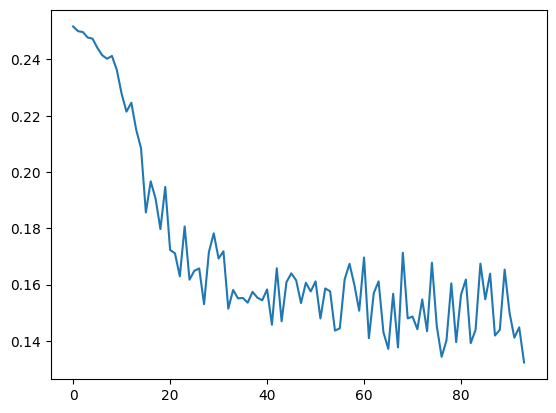

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

torch.save(model.state_dict(), "model_after_train.pt")
plt.plot(all_losses)

In [ ]:
total = len(test_data)
number_right = 0
model.eval()
with torch.no_grad():
  for idx, row in test_data.iterrows():
    text_parts = preprocess_text(str(row['clean_text']))
    label = torch.tensor([row['target']]).float().to(device)

    overall_output = torch.zeros((1,2)).to(device)
    try:
      for part in text_parts:
        if len(part) > 0:
          overall_output += model(part.reshape(1, -1))[0]
    except RuntimeError:
      print("GPU out of memory, skipping this entry.")
      continue

    overall_output = F.softmax(overall_output[0], dim=-1)
    result = overall_output.max(0)[1].float().item()
    if result == label.item():
      number_right += 1

    if idx % print_every == 0 and idx > 0:
      print("{}/{}. Current accuracy: {}".format(idx, total, number_right / idx))

print("Accuracy on test data: {}".format(number_right / total))

300/7092. Current accuracy: 0.9133333333333333
600/7092. Current accuracy: 0.9016666666666666
900/7092. Current accuracy: 0.9022222222222223
1200/7092. Current accuracy: 0.895
1500/7092. Current accuracy: 0.894
1800/7092. Current accuracy: 0.8911111111111111
2100/7092. Current accuracy: 0.8857142857142857
2400/7092. Current accuracy: 0.8875
2700/7092. Current accuracy: 0.8885185185185185
3000/7092. Current accuracy: 0.8843333333333333
3300/7092. Current accuracy: 0.8815151515151515
3600/7092. Current accuracy: 0.8808333333333334
3900/7092. Current accuracy: 0.8817948717948718
4200/7092. Current accuracy: 0.8828571428571429
4500/7092. Current accuracy: 0.8835555555555555
4800/7092. Current accuracy: 0.8829166666666667
5100/7092. Current accuracy: 0.8831372549019608
5400/7092. Current accuracy: 0.8837037037037037
5700/7092. Current accuracy: 0.8842105263157894
6000/7092. Current accuracy: 0.8843333333333333
6300/7092. Current accuracy: 0.8833333333333333
6600/7092. Current accuracy: 0.88